In [8]:
# ============================================================
# ANNUAL -> MONTHLY (données en mois et année)
# - Respect strict des % mensuels (tes paramètres)
# - Effet semaine/week-end + bruit (réalisme) puis agrégation mensuelle
# - Lecture du CSV annuel de base
# - Génère un CSV mensuel final (year, month, site_code, indicateur, ...)
# ============================================================

import pandas as pd
import numpy as np

# ----------------------------
# 1) Lecture du CSV annuel
# ----------------------------
CSV_PATH = "../data/logistics/logistics-data-interpolated.csv"  # adapte si besoin (chemin relatif/absolu)
df_annual = pd.read_csv(CSV_PATH)

# ----------------------------
# 2) Paramètres mensuels (TES %)
# ----------------------------
MONTH_PCT = {
    1: 15,
    2: 10,
    3: 7,
    4: 6,
    5: 5,
    6: 6,
    7: 13,
    8: 13,
    9: 6,
    10: 5,
    11: 4,
    12: 10,
}
if sum(MONTH_PCT.values()) != 100:
    raise ValueError(f"Les pourcentages mensuels doivent faire 100. Total={sum(MONTH_PCT.values())}")

# ----------------------------
# 2a) Paramètres mensuels crise (COVID / tension)
# ----------------------------
MONTH_PCT_COVID = {
    1: 12,   # hiver (tension fréquente)
    2: 8,
    3: 13,   # vague de printemps (hausse)
    4: 14,   # pic printemps
    5: 7,    # décroissance
    6: 4,
    7: 3,
    8: 4,    # reprise possible (fin été)
    9: 5,    # pré-vague
    10: 10,  # vague d'automne (hausse)
    11: 12,  # pic automne
    12: 8,   # fin d'année: tension + inertie de vague
}
if sum(MONTH_PCT_COVID.values()) != 100:
    raise ValueError(f"MONTH_PCT_COVID doit faire 100. Total={sum(MONTH_PCT_COVID.values())}")

# ----------------------------
# 2b) Arrondi par unité (nombre de décimales)
# ----------------------------
ROUNDING_BY_UNIT = {
    "colis": 0,
    "colis/jour": 0,
    "plis": 0,
    "plis/jour": 0,
    "repas": 0,
    "repas/jour": 0,
    "références": 0,
    "kg": 0,
    "t": 2,
    "km": 1,
    "m2": 1,
    "m2/mois": 1,
}
DEFAULT_DECIMALS = 2  # si unité inconnue

# ----------------------------
# 3) Fonction annual -> daily
# ----------------------------
def annual_to_daily(
    annual_value: float,
    year: int,
    month_pct: dict,
    weekend_factor: float = 0.80,  # baisse week-end (logistique/linge/déchets). Pour urgences tu peux mettre >1
    weekday_factor: float = 1.05,  # petit boost en semaine
    noise_sigma: float = 0.08,      # bruit lognormal (0 => pas de bruit)
    seed: int = 42
) -> pd.DataFrame:
    """
    Répartit une valeur annuelle en journalier en respectant strictement les % mensuels,
    tout en ajoutant un effet semaine/week-end et un bruit réaliste.
    """
    rng = np.random.default_rng(seed)

    dates = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="D")
    df = pd.DataFrame({"date": dates})
    df["year"] = year
    df["month"] = df["date"].dt.month
    df["dow"] = df["date"].dt.weekday  # 0=lundi ... 6=dimanche

    values = np.zeros(len(df), dtype=float)

    for m in range(1, 13):
        idx = df.index[df["month"] == m].to_numpy()

        monthly_total = float(annual_value) * (month_pct[m] / 100.0)

        # Effet semaine / week-end
        base = np.where(df.loc[idx, "dow"].to_numpy() >= 5, weekend_factor, weekday_factor).astype(float)

        # Bruit (lognormal => positif)
        if noise_sigma > 0:
            noise = np.exp(rng.normal(loc=0.0, scale=noise_sigma, size=len(idx)))
        else:
            noise = np.ones(len(idx), dtype=float)

        weights = base * noise
        if weights.sum() == 0:
            weights = np.ones_like(weights)

        # Normalisation dans le mois => somme = monthly_total
        values[idx] = monthly_total * (weights / weights.sum())

    df["value"] = values

    # Sécurité numérique: recale exactement la somme annuelle (à cause des floats)
    df.loc[df.index[-1], "value"] += float(annual_value) - df["value"].sum()

    return df[["date", "year", "month", "dow", "value"]]

# ----------------------------
# 4) Vérification (mensuel)
# ----------------------------
def check_monthly_distribution(daily_df: pd.DataFrame, month_pct: dict) -> pd.DataFrame:
    monthly = daily_df.groupby("month")["value"].sum()
    pct_observed = (monthly / monthly.sum() * 100).round(2)
    out = pd.DataFrame({
        "pct_target": pd.Series(month_pct).sort_index(),
        "pct_observed": pct_observed
    })
    out["diff"] = (out["pct_observed"] - out["pct_target"]).round(2)
    return out

# ----------------------------
# 5) Génération journalier pour tout le CSV (PLF & CFX)
# ----------------------------
# Astuce: on adapte les paramètres selon le type d'indicateur (optionnel mais réaliste)
# - logistique (linge/déchets/restauration/colis): week-end baisse
# - urgences (si tu ajoutes ed_passages): week-end peut monter (weekend_factor > 1)
DEFAULT_PARAMS = {
    "weekend_factor": 0.80,
    "weekday_factor": 1.05,
    "noise_sigma": 0.08,
    "seed": 42,
}

all_daily = []

for i, row in df_annual.iterrows():
    year = int(row["ANNEE"])
    indic = row.get("INDICATEUR", "")
    sous_indic = row.get("SOUS-INDICATEUR", "")
    unite = row.get("UNITE", "")

    # Ici tu peux customiser selon indicateur si tu veux
    params = DEFAULT_PARAMS.copy()

    for site in ["PLF", "CFX"]:
        annual_value = row[site]

        # Skip valeurs manquantes
        if pd.isna(annual_value):
            continue

        df_d = annual_to_daily(
            annual_value=float(annual_value),
            year=year,
            month_pct=MONTH_PCT,
            **params
        )

        df_d["site_code"] = site
        df_d["indicateur"] = indic
        df_d["sous_indicateur"] = sous_indic
        df_d["unite"] = unite

        decimals = ROUNDING_BY_UNIT.get(str(unite).strip(), DEFAULT_DECIMALS)
        df_d["value"] = df_d["value"].round(decimals)

        all_daily.append(df_d)

df_daily_all = pd.concat(all_daily, ignore_index=True)

# ----------------------------
# 5b) Agrégation en données mensuelles (mois et année)
# ----------------------------
df_monthly_all = (
    df_daily_all
    .groupby(["year", "month", "site_code", "indicateur", "sous_indicateur", "unite"], as_index=False)
    .agg({"value": "sum"})
)
# Crise: répartition mensuelle selon MONTH_PCT_COVID (même total annuel, profil différent)
df_monthly_all["_annual"] = df_monthly_all.groupby(["year", "site_code", "indicateur", "sous_indicateur"])["value"].transform("sum")
df_monthly_all["value_crise"] = df_monthly_all["_annual"] * df_monthly_all["month"].map(lambda m: MONTH_PCT_COVID[m] / 100)
df_monthly_all = df_monthly_all.drop(columns=["_annual"])
# Réappliquer l'arrondi par unité (value et value_crise)
for unite_val, dec in ROUNDING_BY_UNIT.items():
    mask = df_monthly_all["unite"].astype(str).str.strip() == str(unite_val).strip()
    df_monthly_all.loc[mask, "value"] = df_monthly_all.loc[mask, "value"].round(dec)
    df_monthly_all.loc[mask, "value_crise"] = df_monthly_all.loc[mask, "value_crise"].round(dec)
other = ~df_monthly_all["unite"].astype(str).str.strip().isin([str(u).strip() for u in ROUNDING_BY_UNIT])
df_monthly_all.loc[other, "value"] = df_monthly_all.loc[other, "value"].round(DEFAULT_DECIMALS)
df_monthly_all.loc[other, "value_crise"] = df_monthly_all.loc[other, "value_crise"].round(DEFAULT_DECIMALS)

# ----------------------------
# 5c) Suppression des données vides (même année, indicateur, sous-indicateur, site, mais valeur totale = 0)
# ----------------------------
total_par_groupe = df_monthly_all.groupby(["year", "site_code", "indicateur", "sous_indicateur"])["value"].transform("sum")
df_monthly_all = df_monthly_all[total_par_groupe > 0].copy()

# ----------------------------
# 6) Exemple de contrôle sur un cas
# ----------------------------
example = df_monthly_all.iloc[0:0].copy()
if len(df_monthly_all) > 0:
    first = df_monthly_all.iloc[0]
    example = df_monthly_all[
        (df_monthly_all["year"] == first["year"]) &
        (df_monthly_all["site_code"] == first["site_code"]) &
        (df_monthly_all["indicateur"] == first["indicateur"]) &
        (df_monthly_all["sous_indicateur"] == first["sous_indicateur"])
    ]
    print("---- Vérification % mensuels (exemple) ----")
    pct_obs = (example.groupby("month")["value"].sum() / example["value"].sum() * 100).round(2)
    print(pd.DataFrame({"pct_target": pd.Series(MONTH_PCT).sort_index(), "pct_observed": pct_obs}))

print("\nSomme totale (toutes lignes) =", df_monthly_all["value"].sum())

# Répartition par année / mois / indicateur / sous-indicateur
summary = (
    df_monthly_all
    .groupby(["year", "month", "indicateur", "sous_indicateur"])["value"]
    .sum()
    .reset_index()
    .sort_values(["year", "month", "indicateur", "sous_indicateur"])
)
print("\nRépartition mensuelle par année / indicateur / sous-indicateur :")
print(summary)

# ----------------------------
# 7) Export final (données en mois et année)
# ----------------------------
OUT_PATH = "../data/logistics/logistics-donnees_mensuelles_reconstituees.csv"
df_monthly_all.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"\n✅ Fichier exporté: {OUT_PATH}")

# Aperçu (10 premières lignes)
df_monthly_all.head(10)

---- Vérification % mensuels (exemple) ----
    pct_target  pct_observed
1           15         14.94
2           10         10.02
3            7          6.92
4            6          5.98
5            5          5.07
6            6          5.90
7           13         12.97
8           13         13.08
9            6          6.05
10           5          5.10
11           4          3.97
12          10          9.99

Somme totale (toutes lignes) = 57079873.97

Répartition mensuelle par année / indicateur / sous-indicateur :
      year  month    indicateur  \
0     2011      1       Déchets   
1     2011      1       Déchets   
2     2011      1       Déchets   
3     2011      1       Déchets   
4     2011      1       Déchets   
...    ...    ...           ...   
1471  2016     12  Restauration   
1472  2016     12  Restauration   
1473  2016     12   Vaguemestre   
1474  2016     12   Vaguemestre   
1475  2016     12   Vaguemestre   

                                        sous_ind

,year,month,site_code,indicateur,sous_indicateur,unite,value,value_crise
0,2011,1,CFX,Déchets,Cartons,t,4.10,3.29
1,2011,1,CFX,Déchets,Chimiques,t,0.31,0.19
2,2011,1,CFX,Déchets,Déchets Activités de Soins à Risques Infectieu...,t,7.22,5.76
3,2011,1,CFX,Déchets,Déchets Ménagers Assimilés/Déchets d'Activités...,t,103.50,82.80
4,2011,1,CFX,Déchets,Déchets assimilés aux ordures ménagères,t,100.79,80.64
5,2011,1,CFX,Déchets,Déchets d'Equipements Electriques et Electroni...,t,0.53,0.47
7,2011,1,CFX,Hygiène,Espaces verts,m2,10712.10,8569.60
8,2011,1,CFX,Hygiène,Locaux,m2,6227.50,4982.10
9,2011,1,CFX,Hygiène,Vitres,m2,2802.20,2241.50
10,2011,1,CFX,Hygiène,Voirie,km,59999.90,47999.90


In [7]:
df_daily_all["indicateur"].value_counts()
df_daily_all.groupby(["site_code", "indicateur"]).size()

site_code  indicateur  
CFX        Déchets         14248
           Hygiène          8768
           Lingerie         4384
           Magasin          6576
           Restauration     4384
           Vaguemestre      8768
PLF        Déchets         14248
           Hygiène          8768
           Lingerie         4384
           Magasin          6576
           Restauration     4384
           Vaguemestre      8768
dtype: int64

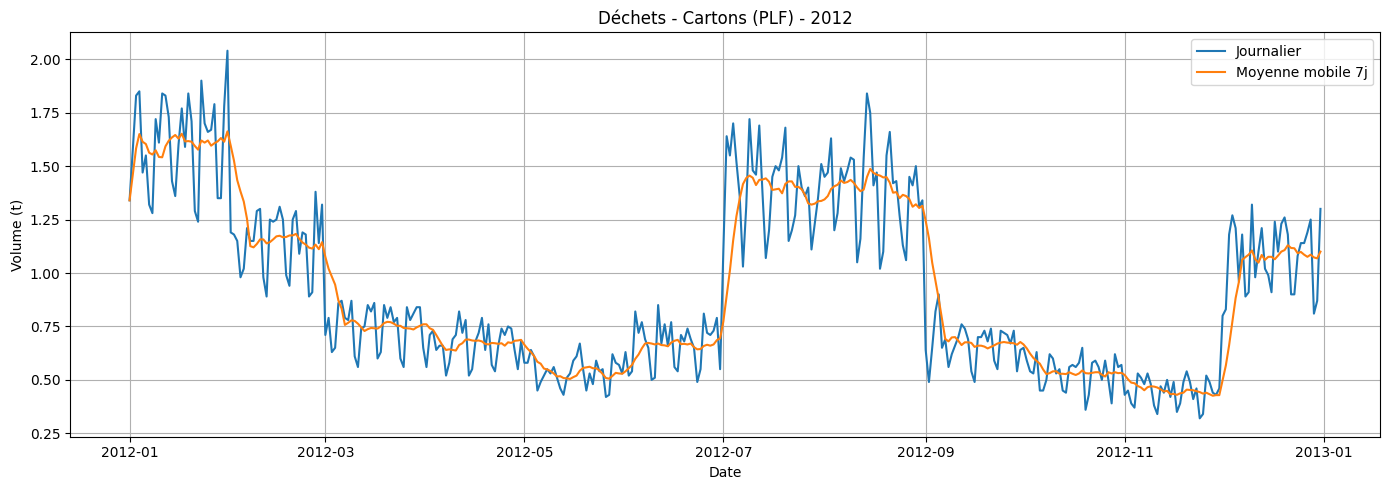

,date,value,unite,mm7
730,2012-01-01,1.34,t,1.340000
731,2012-01-02,1.58,t,1.460000
732,2012-01-03,1.83,t,1.583333
733,2012-01-04,1.85,t,1.650000
734,2012-01-05,1.47,t,1.614000
735,2012-01-06,1.55,t,1.603333
736,2012-01-07,1.32,t,1.562857
737,2012-01-08,1.28,t,1.554286
738,2012-01-09,1.72,t,1.574286
739,2012-01-10,1.61,t,1.542857


In [6]:
# ============================
# Graph: Déchets / Cartons (mensuel)
# - Charge le CSV mensuel reconstitué
# - Filtre Déchets + Cartons
# - Choisit un site (PLF/CFX) et une année
# - Trace la courbe par mois (+ optionnel: moyenne mobile 3 mois)
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# 1) Chemin vers le fichier mensuel généré
MONTHLY_CSV_PATH = "../data/logistics/logistics-donnees_mensuelles_reconstituees.csv"

df = pd.read_csv(MONTHLY_CSV_PATH)

# 2) Date pour l'axe x (1er du mois)
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

# 3) Paramètres du graphe
SITE = "PLF"         # "PLF" ou "CFX"
YEAR = 2012          # année à visualiser

# 4) Filtre: Déchets / Cartons
mask = (
    (df["site_code"] == SITE) &
    (df["year"] == YEAR) &
    (df["indicateur"].str.strip() == "Déchets") &
    (df["sous_indicateur"].str.strip().str.lower() == "cartons")
)

cartons = df.loc[mask, ["date", "year", "month", "value", "unite"]].sort_values("date").copy()

if cartons.empty:
    print("❌ Aucune donnée trouvée pour Déchets / Cartons avec ces filtres.")
    print("➡️ Vérifie les valeurs exactes de 'indicateur' et 'sous_indicateur' avec :")
    print('   df[df["indicateur"]=="Déchets"]["sous_indicateur"].unique()')
else:
    unit = cartons["unite"].iloc[0] if "unite" in cartons.columns and len(cartons) > 0 else ""
    cartons["mm3"] = cartons["value"].rolling(3, min_periods=1).mean()

    # 5) Plot (par mois)
    plt.figure(figsize=(14, 5))
    plt.plot(cartons["date"], cartons["value"], "o-", label="Mensuel")
    plt.plot(cartons["date"], cartons["mm3"], label="Moyenne mobile 3 mois")
    plt.title(f"Déchets - Cartons ({SITE}) - {YEAR} (par mois)")
    plt.xlabel("Mois")
    plt.ylabel(f"Volume ({unit})" if unit else "Volume")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (Optionnel) Aperçu
    display(cartons.head(12))